In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

import os

import random
import cv2

In [5]:
import pathlib
ds_path = "/Users/mantesssa/Projects/nn/nn_tf/BirdVsDrone/"
data_dir = pathlib.Path(ds_path)

image_count = len(list(data_dir.glob('*/*.*')))
# print(image_count) # 828

tree = os.walk(ds_path)

fulllist =[]
for i in tree:
    fulllist.append(i)
    
listofdronesnames = []
for i in fulllist[1][2]:
    if i[-4:] =='jpeg' or i[-4:] =='JPEG' or i[-3:] =='png':
        listofdronesnames.append(i) 
listofdroneslabels = [0]*len(listofdronesnames)

listofbirdsnames = []
for i in fulllist[2][2]:
    if i[-4:] =='jpeg' or i[-4:] =='JPEG' or i[-3:] =='png':
        listofbirdsnames.append(i) # .DS_Store ???
listofbirdslabels = [1]*len(listofbirdsnames)


fulllistnames = listofdronesnames + listofbirdsnames
fulllistlabels = listofdroneslabels + listofbirdslabels
print(len(fulllistnames)) # 825 


list_of_img_matrixes = []

for i in range(len(fulllistlabels)): # len = 825
    if fulllistlabels[i] == 0:
        classnamed = "Drones"
    else:
        classnamed = "Birds"
    img = cv2.imread(ds_path + classnamed + "/" + fulllistnames[i])
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    smallimgb = cv2.resize(RGB_img, (180,180),interpolation=cv2.INTER_CUBIC)
    normsmallimg = smallimgb/ 255
    list_of_img_matrixes.append(normsmallimg)
    
    # if i == 10:
    #     print(normsmallimg)       
    #     plt.imshow(normsmallimg)
        
    





listofindexes = []
for i in range(len(fulllistlabels)): # len = 825
    listofindexes.append(i)

random.shuffle(listofindexes)
shuffledlistofindexes = listofindexes
# print(len(shuffledlistofindexes)) # 800

801


In [6]:
# dataset = 800 indexes from 0 to 799

# 0|   0-39
# 1|   40-79
# 2|   80-119 
# 3|   120-159
# 4|   160-199
# 5|   200-239
# 6|   240-279
# 7|   280-319
# 8|   320-359
# 9|   360-399
# 10|  400-439
# 11|  440-479
# 12|  480-519
# 13|  520-559
# 14|  560-599
# 15|  600-639
# 16|  640-679
# 17|  680-719
# 18|  720-759
# 19|  760-799


class DataGenerator(tf.keras.utils.Sequence):
#     'Generates data for Keras'                      shufled list of indexes
    def __init__(self, fulllistnames, fulllistlabels, list_IDs, is_validation=False, 
                 batch_size=40, dim=(None, 180, 180, 3), n_channels=1, n_classes=2):
        'Initialization'
        self.fulllistnames = fulllistnames
        self.fulllistlabels = fulllistlabels
        self.list_IDs = list_IDs
        self.is_validation = is_validation
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.valid = is_validation
        self.indexes = np.arange(len(self.list_IDs))
        self.number_of_batches = int(np.floor(len(self.list_IDs) / self.batch_size))               # 20
        self.number_of_valid_indexes = 2                                                           # 2
        self.number_of_training_indexes =  self.number_of_batches - self.number_of_valid_indexes   # 18
        self.valind_list_of_indexes = []
        self.training_list_of_indexes = []
        self.valid_index = self.number_of_training_indexes
        self.on_epoch_end()
      
    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.is_validation:
            return self.number_of_valid_indexes # 2
        else:
            return self.number_of_training_indexes # = 18 
 
    def __getitem__(self, index): # index = number of batch from 0 to __len__ 
        if self.is_validation:#if validation set
            indexes = self.valind_list_of_indexes[index*self.batch_size : (index+1)*self.batch_size]      
            list_IDs_temp = [self.list_IDs[k] for k in indexes]
            X, y = self.__data_generation(list_IDs_temp)

        else:#if test set
            indexes = self.training_list_of_indexes[index*self.batch_size : (index+1)*self.batch_size]
            list_IDs_temp = [self.list_IDs[k] for k in indexes]
            X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        if self.valid_index == self.number_of_training_indexes:
            self.valid_index = 0
        else:
            self.valid_index += self.number_of_valid_indexes 
        
        self.indexes = np.arange(len(self.list_IDs))

        self.valind_list_of_indexes = self.indexes[self.valid_index*self.batch_size:(self.valid_index+self.number_of_valid_indexes)*self.batch_size]
        self.training_list_of_indexes = list(set(self.indexes).difference(self.valind_list_of_indexes))

        random.shuffle(self.valind_list_of_indexes)
        random.shuffle(self.training_list_of_indexes)

        # print("self.indexes = ",self.indexes[0:100])
        # print("self.valind_list_of_indexes = ",self.valind_list_of_indexes[0],self.valind_list_of_indexes[-1])
        # print("self.training_list_of_indexes = ",self.training_list_of_indexes[0],self.training_list_of_indexes[-1])

    def __data_generation(self, list_IDs_temp):
        y = []
        X = []
        for ID in (list_IDs_temp):
            classnumber= self.fulllistlabels[ID]
            z = list_of_img_matrixes[ID]
            X.append(z)
            y.append(classnumber) # if drone = 0 if bird = 1
        return np.array(X), keras.utils.to_categorical(y,num_classes=None)
        





In [7]:
allinall = np.array([  #  allinall.shape => (3, 3, 3, 8)  
    [#                       RGB  chanels
    [[0.75, 0.25, 0.25, 0.75, 0.5, 0.5, 1.0, 0.0,]] * 3,      # a11  <= indexes like matrix    first "pixel"    
    [[1.0, 0.0, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25,]] * 3,      # a12
    [[0.75, 0.25, 0.75, 0.25, 1.0, 0.0, 0.5, 0.5,]] * 3,      # a13
    ],
#####
    [
    [[0.5, 0.5, 0.0, 1.0, 0.25, 0.75, 0.75, 0.25,]] * 3,      # a21
    [[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,]] * 3,         # a22
    [[0.5, 0.5, 1.0, 0.0, 0.75, 0.25, 0.25, 0.75,]] * 3,      # a23
    ],
#####
    [
    [[0.25, 0.75, 0.25, 0.75, 0.0, 1.0, 0.5, 0.5,]] * 3,      # a31
    [[0.0, 1.0, 0.5, 0.5, 0.25, 0.75, 0.25, 0.75,]] * 3,      # a32
    [[0.25, 0.75, 0.75, 0.25, 0.5, 0.5, 0.0, 1.0,]] * 3,      # a33
    ],
    ], dtype= np.float32)


print(allinall.shape)
# allinall = tf.convert_to_tensor(allinall)
# print(allinall)
initializer = tf.keras.initializers.Constant(allinall)


(3, 3, 3, 8)


In [8]:
from keras import Model

# Defining model input
input_ =  tf.keras.Input(shape=(180, 180, 3))

# Defining first parallel layer
in_1 = tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', name="initializer_on", kernel_initializer=initializer)(input_)
# conv_1 = tf.keras.layers.BatchNormalization()(in_1)
# conv_1 = AveragePooling2D(pool_size=(2, 2), strides=(3, 3))(conv_1)


# Defining second parallel layer
in_2 = tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', name="initializer_off")(input_)

# Concatenating layers
concat = tf.keras.layers.concatenate([in_1, in_2])
# concat = tf.keras.layers.concatenate([conv_1, conv_2])


minimodel = Model(inputs=[input_], outputs=[concat], name="allinall")
# minimodel.summary()


# for layer in filter(lambda x: 'initializer_on' in x.name, minimodel.layers):
#     weights, bias = map(lambda x: x, layer.get_weights())
    # layer.set_weights([allinall, bias])
    # print("weights = ", tf.is_tensor(weights))
    # print("weights = ", weights)
    # print("bias =",bias)
    # print(initializer)

    # weights_shape, bias_shape = map(lambda x: x.shape, layer.get_weights())
    # print("weights_shape",weights_shape)
    # print("bias_shape",bias_shape)
    # # print(np.full(weights_shape,0))


2023-03-30 20:30:53.283683: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
batch_size = 40
img_height = 180
img_width = 180
class_names = ['Drones', 'Birds']
num_classes = len(class_names)


data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.12),
    layers.RandomZoom(0.3),
  ]
)


# vgg4 == visual geometry group 4
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  minimodel,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.15), # 0.1 work not so well
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs", activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 allinall (Functional)       (None, 180, 180, 16)      448       
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

In [10]:
def scheduler(epoch, lr):
  if epoch < 25:
    return lr
  else:
    return lr * tf.math.exp(-0.9)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# STEPS_PER_EPOCH = 20
# lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
#   0.001,
#   decay_steps=STEPS_PER_EPOCH*50, #100
#   decay_rate=1,
#   staircase=False)

# def get_optimizer():
#   return tf.keras.optimizers.Adam(lr_schedule)## Compile and train the model

# model.compile(optimizer=get_optimizer(),
model.compile(optimizer='adam',
              # loss='binary_crossentropy',
              loss='categorical_crossentropy',
              # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])




In [35]:
#FIT#############################################################################################################

params = {'dim': (None, 180, 180, 3),
          'batch_size': 40,
          'n_classes': 2,
          'n_channels': 1,}

training_generator = DataGenerator(fulllistnames,fulllistlabels,shuffledlistofindexes,False, **params)
validation_generator = DataGenerator(fulllistnames,fulllistlabels,shuffledlistofindexes,True, **params)

# epochs = 10 # n*10 # Do not work
# history = model.fit(training_generator,
#                     validation_data=validation_generator,
#                     epochs=epochs,
#                     use_multiprocessing=True,
#                     workers=6)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="/Users/mantesssa/Projects/nn/nn_tf/logs")

epochs = 10 # n*10
history = model.fit(training_generator,
          validation_data=validation_generator,
          epochs=epochs,
          callbacks=[tensorboard_callback,callback])



Epoch 1/10
18/18 [==============================] - 24s 1s/step - loss: 0.6953 - accuracy: 0.5181 - val_loss: 0.6968 - val_accuracy: 0.4625 - lr: 0.0010
Epoch 2/10
 6/18 [=========>....................] - ETA: 13s - loss: 0.6961 - accuracy: 0.4542

KeyboardInterrupt: 

In [ ]:
# model.save("/Users/mantesssa/Projects/nn/nn_tf/my_model_100e_dropout015")# worked saved all model 
# model.save_weights("/Users/mantesssa/Projects/nn/nn_tf/checkpoints/my_checkpoint_dropout015") # worked saved in checkpoints

(1, 180, 180, 3)


NameError: name 'new_model' is not defined

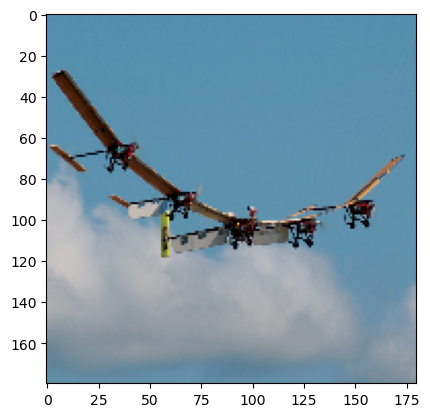

In [10]:
# 3 test imeges
img_path = "/Users/mantesssa/Projects/nn/nn_tf/How-Long-Can-a-Drone-Stay-in-the-Sky_hero.jpeg" # wrong predict
# img_path = "/Users/mantesssa/Projects/nn/nn_tf/drone_opener.jpeg"
# img_path = "/Users/mantesssa/Projects/nn/nn_tf/Egret-to-Sunset.jpeg" # wrong predict  


img = cv2.imread(img_path)
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# smallimg = cv2.resize(RGB_img, (180,180)) 
# smallimgb = cv2.resize(RGB_img, (180,180),interpolation=cv2.INTER_CUBIC) 



img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
img_tensor = tf.keras.utils.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255. #  Изображение нужно приводить к диапазону [0,1]


print(img_tensor.shape) #  (1, 180, 180, 3)


plt.imshow(img_tensor[0])
# plt.show()




input_img = img_path


img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) #  Create a batch

# predictions = model.predict(img_array)
predictions = new_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(score)

print(
    "This image most likely belongs to {} with a {:.2f}% confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [11]:
# model = tf.keras.models.load_model("/Users/mantesssa/Projects/nn/nn_tf/my_model_100e")
# model.summary()

In [12]:
# from keras import models

# # l = model.layers[2]
# layer_outputs = [layer.output for layer in model.layers[2:8]] # only conv layers  2 = conv2d   
# # layer_outputs = [l.output]    
# print(layer_outputs) # 2,4,6
# activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
# acts = activation_model.predict(img_tensor)


# first_layer_activation = acts[0]
# # print(first_layer_activation[0,:,:,7]) # only to 15
# # plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis') # нулевой фильтр




In [13]:
images_per_row = 8

for layer_output, layer_activation in zip(layer_outputs, acts):
    if not layer_output.name.startswith('max'):
        # Количество фильтров в карте признаков
        n_features = layer_activation.shape[-1]
        # Признак имеет форму: (1, высота, ширина, n_features)
        size = layer_activation.shape[1]
        # Разместим результаты активации в виде сетки.
        # На каждой строке будет по images_per_row (16)
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                # Фильтр:
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                # Постобработка, чтобы получить приемлимую визуализацию
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        # Визуализация результатов активации модели TensorFlow
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_output.name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='gray')
plt.show()


NameError: name 'layer_outputs' is not defined

In [14]:
# # summarize filters in each convolutional layer

# summarize filter shapes

for layer in model.layers:
  # check for convolutional layer
  if 'conv' not in layer.name:
    continue
  # get filter weights
  filters, biases = layer.get_weights()
  print(layer.name, filters.shape)

# We can see that all convolutional layers use 3×3 filters, which are small and perhaps easy to interpret.


conv2d (3, 3, 16, 16)
conv2d_1 (3, 3, 16, 32)
conv2d_2 (3, 3, 32, 64)
conv2d_3 (3, 3, 64, 128)


In [15]:
# new_model = tf.keras.models.load_model("/Users/mantesssa/Projects/nn/nn_tf/my_model_100e")
# new_model.summary()

In [16]:
# # # plot feature map of first conv layer for given image
# # from keras.applications.vgg16 import VGG16
# # from keras.applications.vgg16 import preprocess_input
# # from keras.preprocessing.image import load_img
# # from keras.preprocessing.image import img_to_array
# # from keras.models import Model
# # from matplotlib import pyplot
# # from numpy import expand_dims
# # load the model
# # model = VGG16()
# # redefine model to output right after the first hidden layer


# # new_model = tf.keras.models.load_model("/Users/mantesssa/Projects/nn/nn_tf/my_model_100e")






# # model = Model(inputs=model.inputs, outputs=model.layers[2].output)





# # l = model.layers[2]
# layer_outputs = [layer.output for layer in new_model.layers[2:8]] # only conv layers  2 = conv2d   
# # layer_outputs = [l.output]    
# # print(layer_outputs) # 2,4,6
# activation_model = models.Model(inputs=new_model.input, outputs=layer_outputs)
# # activation_model = models.Model(inputs=new_model.layers[2], outputs=layer_outputs)


# # acts = activation_model.predict(img_tensor)
# # print("activation_model: ")
# activation_model.summary()


# # load the image with the required shape
# img = tf.keras.utils.load_img(img_path, target_size=(180, 180))
# # convert the image to an array
# img = tf.keras.utils.img_to_array(img)
# # expand dimensions so that it represents a single 'sample'
# img = tf.expand_dims(img, axis=0)
# # prepare the image (e.g. scale pixel values for the vgg)
# img = tf.keras.applications.resnet50.preprocess_input(img)
# # get feature map for first hidden layer
# feature_maps = model.predict(img)
# # plot all 64 maps in an 8x8 squares
# square = 2
# ix = 1
# for _ in range(square):
# 	for _ in range(square):
# 		# specify subplot and turn of axis
# 		ax = plt.subplot(square, square, ix)
# 		ax.set_xticks([])
# 		ax.set_yticks([])
# 		# plot filter channel in grayscale
# 		plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
# 		ix += 1
# # show the figure
# plt.show()

In [1]:
testmod = model.layers[2]
filters, biases = testmod.layers[1].get_weights()
# filters, biases = model.layers[2].get_weights()
print(model.layers[2].name, filters.shape)
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters =8
ix = 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		print(f[:, :, j])
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()



# example of plotting the first six filters from the first convolutional layer (conv2d) with shape (3, 3, 3, 16)
# black = 0 
# white = 1 

# img_array = tf.keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch

# ll = tf.image.sobel_edges(img_array)
# ll.numpy()
# # plt.imshow(ll, cmap='gray')
# # cv2.imshow(ll)
# plt.imshow(ll)

# sobel= tf.image.sobel_edges(img_array)
# print("sobel.shape",sobel.shape)
# # cv2.imshow("image", img_array)
# sobel_x = np.asarray(sobel[0, :, :, :, 0])  #  Sobel_X
# sobel_y = np.asarray(sobel[0, :, :, :, 1])  #  Sobel_Y

# plt.subplot(1, 2, 1)
# plt.imshow(sobel_x)
# plt.subplot(1, 2, 2)
# plt.imshow(sobel_y)


NameError: name 'model' is not defined

In [ ]:
# new_model = tf.keras.models.load_model("/Users/mantesssa/Projects/nn/nn_tf/my_model_100e")
# new_model.summary()

In [ ]:
######################################################
test_path = "/Users/mantesssa/Projects/nn/nn_tf/testDS/"    # it works 

tree = os.walk(test_path)

fulllist = []
for i in tree:
    fulllist.append(i)
    
listofdronesnames = []
for i in fulllist[1][2]:
    if i[-4:] =='jpeg' or i[-4:] =='JPEG' or i[-3:] =='png':
        listofdronesnames.append(i)
listofdroneslabels = [0]*len(listofdronesnames)

listofbirdsnames = []
for i in fulllist[2][2]:
    if i[-4:] =='jpeg' or i[-4:] =='JPEG' or i[-3:] =='png':
        listofbirdsnames.append(i) # .DS_Store ???
listofbirdslabels = [1]*len(listofbirdsnames)




fulllistnames = listofdronesnames + listofbirdsnames
fulllistlabels = listofdroneslabels + listofbirdslabels
print(len(fulllistnames)) # 825 
print(len(fulllistlabels)) # 825 


# list_of_test_img_matrixes = []

img_height = 180
img_width = 180

for i in range(len(fulllistlabels)): # len = 825
    if fulllistlabels[i] == 0:
        classnamed = "Drones"
    else:
        classnamed = "Birds"
    img_path = test_path + classnamed + "/" + fulllistnames[i]


    img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) #  Create a batch


    predictions = new_model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    print(img_path)
    print(
    "____ {} ______ with a {:.2f}% confidence."
    # "This image most likely belongs to ____ {} ______ with a {:.2f}% confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
    )


In [89]:
####################################################################################### pre loaded images version 
list_of_test_img_matrixes = []

for i in range(len(fulllistlabels)): # len = 825
    true_label_num = fulllistlabels[i]
    if true_label_num == 0:
        classnamed = "Drones"
    else:
        classnamed = "Birds"
    path_to_img = test_path + classnamed + "/" + fulllistnames[i]

    # img = cv2.imread(path_to_img)
    # RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # smallimgb = cv2.resize(RGB_img, (180,180),interpolation=cv2.INTER_CUBIC)

    img = tf.keras.utils.load_img(path_to_img, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) #  Create a batch
    # print(img_array.shape)

    # img_path = test_path + classnamed + "/" + fulllistnames[i]
    # img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
    # img_array = tf.keras.utils.img_to_array(img)
    # img_array = tf.expand_dims(img_array, 0) #  Create a batch
    # predictions = new_model.predict(img_array)

    # normsmallimg = smallimgb/ 255.
    list_of_test_img_matrixes.append([img_array, true_label_num]) #?????

In [1]:
false_class_num =0
for i in range(len(fulllistlabels)): # len = 825
    # if fulllistlabels[i] == 0:
    #     classnamed = "Drones"
    # else:
    #     classnamed = "Birds"
    # img_path = test_path + classnamed + "/" + fulllistnames[i]


    # img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
    test_img = list_of_test_img_matrixes[i][0]
    label_num = list_of_test_img_matrixes[i][1]
    # plt.imshow(test_img)
    # plt.show()
    # print (np.array(test_img).shape)
    # print (label_num)

    # img_array = tf.keras.utils.img_to_array(test_img)
    # img_array = tf.expand_dims(img_array, 0) #  Create a batch

    predictions = new_model.predict(test_img)
    tf.keras.backend.clear_session()
    score = tf.nn.softmax(predictions[0])
    if label_num == np.argmax(score):
        false_class_num += 1
    print(
    "This image most likely belongs to {} with a {:.2f}% confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

print("test_accuracy = ",false_class_num/len(fulllistlabels))


NameError: name 'fulllistlabels' is not defined